# Analyse descriptive de la base de données 

### Importation de la base

In [207]:
import pandas as pd 
import matplotlib.pyplot as plt
from functools import reduce
from operator import add
from tqdm import tqdm

import spacy
from spacy import displacy
from spacy.tokenizer import Tokenizer
from spacy.lang.fr import French
from collections import Counter
import re
import fr_core_news_sm,fr_core_news_lg
nlp = fr_core_news_lg.load()

In [156]:
df = pd.read_csv("2019-01-08-editos-radio.csv")

On enlève les "\n" 

In [157]:
df['auteur'] = df['auteur'].apply(lambda x: " ".join(str(x).split()))

In [158]:
df['texte']= df['texte'].apply(lambda x: " ".join((str(x).split())))

### Statistiques descriptives textuelles

- Nombre de phrases 

In [5]:
def split(text, delimiters = [".","?","!","..."], maxsplit=0):
    #fonction servant juste à séparer les phrases dans un texte sous forme de liste
    delimiters = '|'.join(map(re.escape, delimiters))
    phrases = re.split(delimiters, text, maxsplit)
    return(list(filter(lambda a: a != '', phrases)))

In [6]:
def nombre_phrases(text):
    return(len(split(text)))

In [7]:
df['Nombre phrases'] = df['texte'].apply(nombre_phrases)

- Phrases interrogatives

In [8]:
df['Interrogatives'] = df['texte'].apply(lambda x : x.count('?'))
df['Pourcentage interrogatives']=round((df['Interrogatives']/df['Nombre phrases'])*100,2)
print("Proportion de phrases interrogatives : ", df['Pourcentage interrogatives'].mean(), '%')

Proportion de phrases interrogatives :  6.540354609929105 %


Est-ce notable ? A comparer.

#### Des différences stylistiques entre les éditorialistes ?

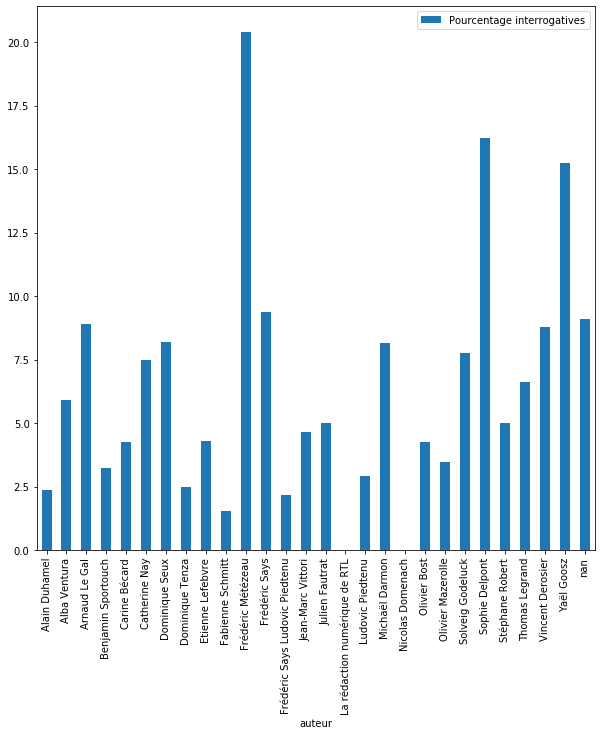

In [18]:
pd.DataFrame(df.groupby('auteur').mean().reset_index()).plot.bar(x='auteur', y='Pourcentage interrogatives', figsize=(10,10))

- Repères (lieux, personnes)

In [5]:
def counter_label(text,label):
    doc=nlp(text)
    c=0
    for ent in doc.ents:
        if ent.label_ == label:
            c+=1
    return(c)

In [10]:
df['Lieux'] = df['texte'].apply(lambda x: counter_label(x,'LOC'))

KeyboardInterrupt: 

In [21]:
df['Personnes'] = df['texte'].apply(lambda x: counter_label(x,'PER'))

In [22]:
df['Lieux par phrase'] = round((df['Lieux']/df['Nombre phrases']),2)
df['Personnes par phrase'] = round((df['Personnes']/df['Nombre phrases']),2)

- Chiffres / Pourcentage

In [27]:
df['Pourcentages'] = df['texte'].apply(lambda x : x.count('%'))
df['Pourcentages par phrase'] = round((df['Pourcentages']/df['Nombre phrases']),2)

### Personnalités politiques 

Afin de reveler les personnalités politiques citées dans un édito, on crée une liste composées des présidents et ministres de la
Ve République à laquelle on a rajouté les députés et sénateurs en activité, puis les eurodéputés élus en 2019 ainsi que les candidats à la présidentielle de 2017.

In [6]:
%run Scrap_perso_politiques_Fr.ipynb

2e manière : un Phrase matcher de SpaCy

In [7]:
POLITICIANS = Ministres_Ve + Presidents + Deputes + Senateurs + eurodeputes + Candidats_2017
POLITICIANS += ['JL Mélenchon', 'Marine le Pen', 'J.L. Mélenchon', 'JL. Mélenchon', 'Benoit Hamon']

# On importe le PhraseMatcher et on l'initialise
from spacy.matcher import PhraseMatcher
matcher_politician = PhraseMatcher(nlp.vocab)

# On crée des motifs objets et  on les ajoute au matcher

patterns = list(nlp.pipe(POLITICIANS))
matcher_politician.add("Politicians", None, *patterns, on_match=True)

In [11]:
# Appelle le matcher sur le document de test et affiche le résultat

essai =" François Hollande devrait s'appuyer sur Michel Sapin et son expérience. François Hollande contre Gérard Larcher,Mélenchon"
doc_essai = nlp(essai)
matches_essai = matcher_politician(doc_essai)
print([[doc_essai[start:end] for match_id, start, end in matches_essai],len(matches_essai)])

[[François Hollande, Michel Sapin, François Hollande, Gérard Larcher], 4]


- Si le nom d'un politique n'apparait pas en entier il n'est pas relevé par le Matcher. (résolu)
- En ajoutant les noms seuls, à la liste des noms prénoms, on a un problème pour les entités qui se chevauchent (Hollande dans François Hollande) (résolu)
- Le matcher relève le nom d'une personnalité politique autant de fois qu'elle est citée, si on s'intéresse aux nombres de citations
différentes on mettra un *set()*

In [12]:
def expressions_extraction(texte,matcher):
    doc = nlp(texte)
    matches = matcher(doc)
    return([doc[start:end] for match_id, start, end in matches])

In [13]:
expressions_extraction(essai,matcher_politician)

[François Hollande, Michel Sapin, François Hollande, Gérard Larcher]

In [ ]:
#df['matcher'] = df['texte'].apply(lambda x : expressions_extraction(x, matcher))
#df['taille matcher'] = df['matcher'].apply(len)

##### Création d'une nouvelle entité nommée : Politicien (POL)

In [208]:
from spacy.tokens import Span

def politician_component(doc):
    # Crée une entité Span avec le label "POL" pour toutes les correspondances
    matches = matcher_politician(doc)
    doc.ents = [Span(doc, start, end, label='POL') for match_id, start, end in matches]
    return doc


# Ajoute le composant au pipeline
nlp.add_pipe(politician_component, before='ner')
print(nlp.pipe_names)

['tagger', 'parser', 'politician_component', 'ner']


On ajoute le composant à la recherche des noms de familles de politiciens, ceci règle le problème de non-repérage lorsqu'une personnalité politique est désignée par son nom.

In [209]:
POLITICIANS_surname = [politicien.split()[-1] for politicien in POLITICIANS]

def politicians_surnames(doc):
    new_ents = []
    for ent in doc.ents:
            if ent.text in POLITICIANS_surname:
                new_ent = Span(doc, ent.start, ent.end, label='POL')
                new_ents.append(new_ent)
            else:
                new_ents.append(ent)
    doc.ents = new_ents
    return doc

nlp.add_pipe(politicians_surnames, after='ner')
print(nlp.pipe_names)

['tagger', 'parser', 'politician_component', 'ner', 'politicians_surnames']


In [181]:
#df['Politiques'] = df['texte'].apply(lambda x: counter_label(x,'POL'))

In [210]:
text = nlp(df.loc[10]['texte'])
displacy.render(text, style='ent')

In [24]:
#pd.DataFrame(df.groupby('auteur').mean().reset_index()).plot.bar(x='auteur', y='Politiques', figsize=(10,10))

On note d'importante disparités, d'un editorialiste à un autre,dans l'évocation de figures politiques (Présidents, ministres (actuels et anciens), députés, eurodéputés, sénateurs, candidats à la présidentielle 2017)

Afin de pouvoir relever correctements les personalités politiques cités, on a besoin de "fusionner" certains résultats

In [25]:
texte = nlp(df['texte'][7])
liste=[ent.text for ent in texte.ents if ent.label_ =='POL']
compteur=[(element,liste.count(element)) for element in set(liste)]
compteur

[('Manuel Valls', 4), ('François Hollande', 3), ('Hollande', 1)]

In [139]:
def fusion(l1,l2):
    liste_fusion=[]
    liste_somme=l1+l2
    for nom, comptage in liste_somme:
        for name, count in liste_somme:
            if nom.split()[-1] == name.split()[-1] and nom != name: #la fin du nom apparaît dans la liste
                liste_somme.remove((nom, comptage))
                liste_somme.remove((name, count))
                if len(nom)>len(name):
                    liste_fusion += [(nom, comptage + count)]
                else:
                    liste_fusion += [(name, comptage + count)]
            elif nom == name and comptage != count:
                liste_somme.remove((nom, comptage))
                liste_somme.remove((name, count))
                liste_fusion += [(nom, comptage + count)]
                
    return(liste_fusion + liste_somme)

In [140]:
def tri_fusion(liste):
    if  len(liste) <= 1: 
        return liste
    else:
        pivot = len(liste)//2
        liste1 = liste[:pivot]
        liste2 = liste[pivot:]
        gauche = tri_fusion(liste1)
        droite = tri_fusion(liste2)
        fusionne = fusion(gauche,droite)
        return fusionne

On crée une nouvelle DataFrame qui relève toutes les citations de personnalités politique, par éditorialiste.

In [211]:
Editorialistes = [auteur for auteur in set(df.auteur)]
df_citations = pd.DataFrame(columns=['Auteur', 'Personnalité', 'Nb Citations'])

for editorialiste in tqdm(Editorialistes):
    base = df[df['auteur']==editorialiste]
    editos = base.texte
    docs = list(nlp.pipe(editos)) #on traite directement tous les textes en même temps, c'est bcp plus rapide
    ents = [doc.ents for doc in docs]

    liste=[]
    for i in range(len(ents)):
        liste += [ent.text for ent in ents[i] if ent.label_ == 'POL']
    
    compteur=[(element,liste.count(element)) for element in set(liste)]
    compteur_fusion = tri_fusion(compteur) 
    
    for personnalite, nombre in compteur_fusion:
        df_citations=df_citations.append({'Auteur': editorialiste ,'Personnalité': personnalite ,'Nb Citations': nombre}, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [03:08<00:00,  6.72s/it]


In [91]:
Legrand_citations = df_citations[df_citations['Auteur']== 'Thomas Legrand']
Top_20 = Legrand_citations[['Personnalité','Nb Citations']].sort_values(by='Nb Citations',ascending=False).head(20)

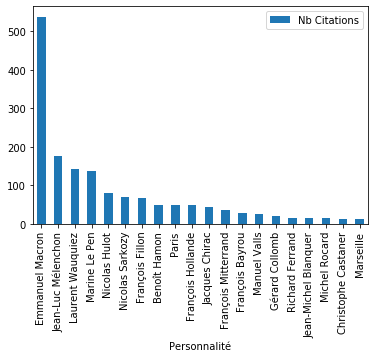

In [94]:
Top_20.plot(x='Personnalité', kind = 'bar')

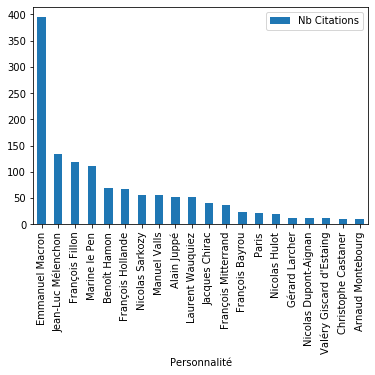

In [103]:
Duhamel_citations = df_citations[df_citations['Auteur']== 'Alain Duhamel']
Top_20 = Duhamel_citations[['Personnalité','Nb Citations']].sort_values(by='Nb Citations',ascending=False).head(20)
Top_20.plot(x='Personnalité', kind = 'bar')

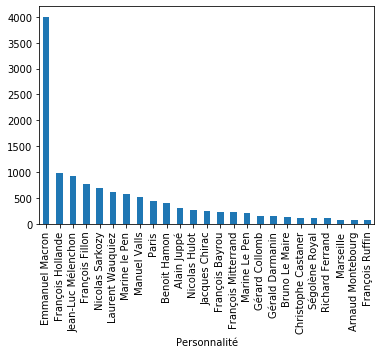

In [221]:
df_citations.groupby('Personnalité')['Nb Citations'].sum().sort_values(ascending=False).head(25).plot(kind='bar')

Emmanuel Macron, ministre, candidat à la présidentielle puis président de la République est la personnalité politique la plus citée. Vient ensuite Francçois Hollande, président pendant toute la période pré-campagne et campagne. Les (gros) candidats à la présidentielle 2017 sont également beacoup cités, du fait de l'année d'élection présidentielle 2017. D'anciens présidents comme Jacques Chirac ou François Mitterand sont fréquement cités.

Il est important de garder en tête que l'algorithme de trouve que ce qu l'on lui fait chercher, à savoir des noms issus d'une liste de ministres et présidents (passés et actuels), députés, sénateurs , eurodéputés et candidats en 2017. Et les noms à orthographes multiples peuvent se retrouver sous plusieurs formes. 
L'exemple qui suit le montre bien :

In [241]:
df_citations[df_citations['Personnalité']=='Marine le Pen']

,Auteur,Personnalité,Nb Citations
40,Alba Ventura,Marine le Pen,272
181,Catherine Nay,Marine le Pen,28
443,Julien Fautrat,Marine le Pen,11
528,Olivier Bost,Marine le Pen,22
828,Thomas Legrand,Marine le Pen,138
945,Alain Duhamel,Marine le Pen,111


In [242]:
df_citations[df_citations['Personnalité']=='Marine Le Pen']

,Auteur,Personnalité,Nb Citations
13,Frédéric Says Ludovic Piedtenu,Marine Le Pen,4
264,Carine Bécard,Marine Le Pen,3
293,Michaël Darmon,Marine Le Pen,13
349,Vincent Derosier,Marine Le Pen,1
357,Dominique Tenza,Marine Le Pen,1
367,Frédéric Métézeau,Marine Le Pen,2
389,Ludovic Piedtenu,Marine Le Pen,8
427,Benjamin Sportouch,Marine Le Pen,2
452,Olivier Mazerolle,Marine Le Pen,4
475,Dominique Seux,Marine Le Pen,13


### "Expertise canonisée" : rapports, études, chiffres

#### Utilisation d'un matcher, pour trouver des expressions.
- Ici on veut repérer la citation d'un rapport ou d'une étude

In [28]:
from spacy.matcher import Matcher
matcher_rapport = Matcher(nlp.vocab)

# On écrit un motif pour le mot rapport et les mots qui le suivent habituellement
pattern = [{"lower": "rapport"},{"POS": "ADP", "OP":"?"},{"POS": "DET", "OP":"?"}, {"POS": "PROPN", "OP":"+"}]
pattern_date=[{"lower": "rapport"},{"POS": "ADP", "OP":"?"},{"POS": "DET", "OP":"?"}, {"POS": "PROPN", "OP":"?"},
           {"POS": "ADP", "OP":"?"},{"POS": "NUM","OP":"+"}]
pattern_theme = [{"lower": "rapport"},{"POS": "ADP", "OP":"?"},{"POS": "DET", "OP":"?"}, {"POS": "NOUN", "OP":"+"}]

# On reprend les mêmes motifs pour une étude
pattern_etude = [{"lower": "étude"},{"POS": "ADP", "OP":"?"},{"POS": "DET", "OP":"?"}, {"POS": "PROPN", "OP":"+"}]
pattern_etude_date=[{"lower": "étude"},{"POS": "ADP", "OP":"?"},{"POS": "DET", "OP":"?"}, {"POS": "PROPN", "OP":"?"},
           {"POS": "ADP", "OP":"?"},{"POS": "NUM","OP":"+"}]
pattern_etude_theme = [{"lower": "étude"},{"POS": "ADP", "OP":"?"},{"POS": "DET", "OP":"?"}, {"POS": "NOUN", "OP":"+"}]

# Ajoute les motifs au matcher et applique le matcher au doc
matcher_rapport.add("Rapport_PATTERN", None, pattern)
matcher_rapport.add("Rapport_PATTERN_date",None,pattern_date)
matcher_rapport.add("Rapport_PATTERN_date",None,pattern_theme)
matcher_rapport.add("Etude_PATTERN", None, pattern_etude)
matcher_rapport.add("Etude_PATTERN_date",None,pattern_etude_date)
matcher_rapport.add("Etude_PATTERN_date",None,pattern_etude_theme)

In [29]:
# Un essai
doc=nlp('Le rapport sur le Climat, Un rapport de 2014, Une étude sur les Gilets Jaunes, Le rapport Borloo, Le rapport Borloo 2019, Le rapport du GIEC, Le rapport de Jean-Louis Borloo, Le rapport du FMI 2012, un rapport de 2012 climat')
matches = matcher_rapport(doc)
print("Nombre de correspondances trouvées :", len(matches))

for match_id, start, end in matches:
    #print("Correspondance trouvée :", doc[start:end].text)
    print(str(doc[start:end]))

Nombre de correspondances trouvées : 12
rapport sur le Climat
rapport de 2014
étude sur les Gilets
rapport Borloo
rapport Borloo
rapport Borloo 2019
rapport du GIEC
rapport de Jean-Louis
rapport de Jean-Louis Borloo
rapport du FMI
rapport du FMI 2012
rapport de 2012


In [30]:
matches

[(4598983933710814491, 1, 5),
 (4598983933710814491, 7, 10),
 (18228608638618684870, 12, 16),
 (14327792050826832101, 19, 21),
 (14327792050826832101, 23, 25),
 (4598983933710814491, 23, 26),
 (14327792050826832101, 28, 31),
 (14327792050826832101, 33, 36),
 (14327792050826832101, 33, 37),
 (14327792050826832101, 39, 42),
 (4598983933710814491, 39, 43),
 (4598983933710814491, 45, 48)]

Note: On veut supprimer les expressions qui sont contenues dans d'autres expressions identifiées par le matcher

In [82]:
def clear_matcher_rapport(doc):
    matches = matcher_rapport(doc)
    matches_clear=[]
    for i in range(len(matches[:-1])):
        match_id, start, end = matches[i]
        machid, debut, fin = matches[i+1]
        if not str(doc[debut:fin]).startswith(str(doc[start:end])):
            matches_clear+=[(match_id, start, end)]
    if matches_clear != []:
        matches_clear += [matches[-1]]
    return(matches_clear)

In [83]:
for match_id, start, end in clear_matcher_rapport(doc):
    #print("Correspondance trouvée :", doc[start:end].text)
    print(str(doc[start:end]))

rapport sur le Climat
rapport de 2014
étude sur les Gilets
rapport Borloo 2019
rapport du GIEC
rapport de Jean-Louis Borloo
rapport du FMI 2012
rapport de 2012


In [84]:
#df['rapports_etudes'] = df['texte'].apply(lambda x : expressions_extraction(x, clear_matcher_rapport))
#df['taille_rapports_etudes'] = df['rapports_etudes'].apply(len)

- On essaie désormais de repérer les occurrences de données chiffrées

In [85]:
essai=nlp('2 millions de Français, un français sur 30 n\'est pas  favorable, 60% du PIB, 2017 un million, deux millions')

In [86]:
from spacy.matcher import Matcher

# Crée les motifs de correspondance
pattern1 = [{"POS" : "NUM"}, {"POS": "DET","OP": "?"},{"POS": "NOUN","OP": "?"}]
pattern2 = [{"LIKE_NUM" : True}, {"Lower" : "million"}]
pattern3 = [{"LIKE_NUM" : True}, {"Lower" : "milliard"}]

# Initialise le Matcher et ajoute les motifs
matcher_chiffres = Matcher(nlp.vocab)
matcher_chiffres.add("PATTERN1", None, pattern1)
matcher_chiffres.add("PATTERN1", None, pattern2)
matcher_chiffres.add("PATTERN1", None, pattern3)

# Itère sur les correspondances
for match_id, start, end in matcher_chiffres(essai):
    # Affiche le nom de la chaine et le texte de la portion en correspondance
    print(essai.vocab.strings[match_id], essai[start:end].text)

PATTERN1 2
PATTERN1 2 millions
PATTERN1 60
PATTERN1 60%
PATTERN1 un million
PATTERN1 deux
PATTERN1 deux millions


In [168]:
def clear_matcher_chiffres(doc):
    matches = matcher_chiffres(doc)
    matches_clear=[]
    for i in range(len(matches[:-1])):
        match_id, start, end = matches[i]
        machid, debut, fin = matches[i+1]
        if not str(doc[debut:fin]).startswith(str(doc[start:end])):
            matches_clear+=[(match_id, start, end)]
    if matches_clear != []:
        matches_clear += [matches[-1]]
    return(matches_clear)

In [92]:
test = nlp('Ya pas de chiffres dans ce test')

In [89]:
for match_id, start, end in clear_matcher_chiffres(essai):
    #print("Correspondance trouvée :", doc[start:end].text)
    print(str(essai[start:end]))

2 millions
60%
un million
deux millions


- Combinaison des 2 dans une entité nommé 'EXP' pour "Expertise"

In [214]:
def rapport_component(doc):
    # Crée une entité Span avec le label "EXP" pour toutes les correspondances
    matches = clear_matcher_rapport(doc) 
    doc.ents = [Span(doc, start, end, label='EXP') for match_id, start, end in matches]
    return doc


# Ajoute le composant au pipeline
nlp.add_pipe(rapport_component, before ='ner')
print(nlp.pipe_names)

['tagger', 'parser', 'politician_component', 'rapport_component', 'ner', 'politicians_surnames']


In [216]:
def chiffres_component(doc):
    # Crée une entité Span avec le label "EXP" pour toutes les correspondances
    matches = clear_matcher_chiffres(doc)
    doc.ents = [Span(doc, start, end, label='EXP') for match_id, start, end in matches]
    return doc


# Ajoute le composant au pipeline
nlp.add_pipe(chiffres_component, before ='ner')
print(nlp.pipe_names)

['tagger', 'parser', 'politician_component', 'rapport_component', 'chiffres_component', 'ner', 'politicians_surnames']


In [93]:
Editorialistes = [auteur for auteur in set(df.auteur)]
df_expertise = pd.DataFrame(columns=['Auteur', 'Citations', 'Nbre'])

with nlp.disable_pipes("politician_component", "politicians_surnames"): #pour éviter que certains composents n'en fassent oublier d'autres

    for editorialiste in tqdm(Editorialistes):
        base = df[df['auteur']==editorialiste]
        editos = base.texte
        docs = list(nlp.pipe(editos)) #on traite directement tous les textes en même temps, c'est bcp plus rapide
        ents = [doc.ents for doc in docs]

        liste=[]
        for i in range(len(ents)):
            liste += [ent.text for ent in ents[i] if ent.label_ == 'EXP']

        compteur=[(element,liste.count(element)) for element in set(liste)]

        for citation, nombre in compteur:
            df_expertise = df_expertise.append({'Auteur': editorialiste , 'Citations': citation, 'Nbre': nombre}, ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 28/28 [03:15<00:00,  7.00s/it]


In [137]:
df_expertise.sample(15)

,Auteur,Citations,Nbre
5782,Alain Duhamel,2025,1
3529,Dominique Seux,trois acteurs,2
4590,Frédéric Says,11 octobre,1
2046,Michaël Darmon,deux régions,1
5891,Alain Duhamel,"12,5%",1
1454,Catherine Nay,67 millions,1
2277,Ludovic Piedtenu,11 octobre,1
3053,Dominique Seux,1957,2
3297,Dominique Seux,83 milliards,3
4455,Frédéric Says,quatre formations,1


On se rend compte que dans les évocations de ce qu'on attend comme étant des 'Données chiffrées', un bon nombre de dates et des nombres qui n'ont pas grand choses à voir avec l'argumentation apparaissent. On peut au moins espérer que si notre 'filet' a des mailles trop fines, on ne rate pas grand chose...

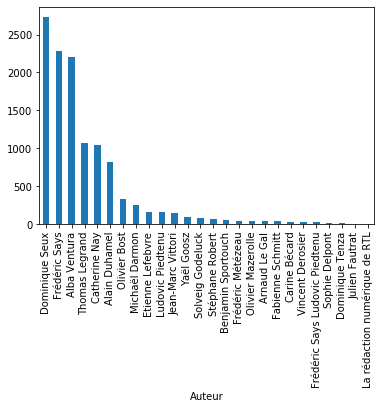

In [245]:
df_expertise.groupby('Auteur')['Nbre'].sum().sort_values(ascending=False).plot(kind='bar')

Dominique Seux est celui qui utilise le plus de données 'd'expertise', étant un analyste économique quand les autres sont des analystes politiques, on est presque rassuré de trouver ce résultat.

### Mise en exergue des entités nommées dans un texte

In [51]:
Legrand = df[df['auteur']=='Thomas Legrand']
Legrand = Legrand.reset_index()

Seux = df[df['auteur']=='Dominique Seux']
Seux = Seux.reset_index()

In [219]:
with nlp.disable_pipes("politician_component", "politicians_surnames"):
    texte=nlp(Seux['texte'][3])
    displacy.render(texte, style='ent')

# Entraînement d'un nouveau modèle 

Jusque là, il était nécessaire de fournir dans notre code, soit une liste de noms à détecter, soit des règles très précises pour repérer certaines phrases. On se propose de dépasser ce stade de l'analyse en entrainant les modèles.

Le premier essai d'apprentissage concerne le repérage, dans un texte, d'une date.

In [91]:
# Crée un modèle "en" vide
nlp_date = spacy.blank("fr")

# Crée un nouvel entity recognizer et ajoute-le au pipeline
ner = nlp_date.create_pipe("ner")
nlp_date.add_pipe(ner)

# Ajoute le label "DATE" à l'entity recognizer
ner.add_label("DAT")

In [127]:
#("phrase", {"entities": [(15, 24, "LABEL")]},)

TRAINING_DATA = [
    ("Nous sommes en 2021", {'entities': [(15, 19, 'DAT')]},),
    ('En sciences sociales comme en sciences la démarche se veut scientifique', {'entities': []},),
    ('La dernière coupe du monde à eu lieu en 2018', {'entities': [(40, 44, "DAT")]},),
    ('Il faut comprendre que 2014 est une date', {'entities': [(23, 27, "DAT")]},),
    ('Le 19 octobre 2019, j\'ai eu 20 ans', {'entities': [(3, 18, 'DAT' )]},),
    ('La  culture de Soja détruit la forêt amazonienne', {'entities': []},),
    ('Le Premier ministre adressera ses voeux aux français le 27 Janvier', {'entities': [(56,66, 'DAT')]},),
    ('L\'année 1933 Adol Hitler a été élu Chancelier d\'Allemagne', {'entities': [(8, 12, 'DAT')]},),
    ('Les éléctions européennes de 2019 ont confirmé la bonne dynamique des partis écolos', {'entities': [(29, 33, 'DAT')]},)
]

In [129]:
import random 

# Commence l'apprentissage
nlp_date.begin_training()

# Boucle pour 20 itérations
for itn in range(20):
    # Mélange les données d'apprentissage
    random.shuffle(TRAINING_DATA)
    losses = {}

    # Répartis les exemples en lots et itère dessus
    for batch in spacy.util.minibatch(TRAINING_DATA):
        texts = [text for text, entities in batch]
        annotations = [entities for text, entities in batch]

        # Actualise le modèle
        nlp_date.update(texts, annotations, losses=losses)
    print(losses)

{'ner': 3.593495143907675e-15}
{'ner': 1.7026498935555848e-15}
{'ner': 9.58089724399704e-16}
{'ner': 6.900062769853091e-16}
{'ner': 4.910405409975596e-16}
{'ner': 4.4054115940722274e-16}
{'ner': 4.264395357994734e-16}
{'ner': 4.570458262620127e-16}
{'ner': 5.241283047157466e-16}
{'ner': 6.260246541218143e-16}
{'ner': 8.389692751734323e-16}
{'ner': 9.775718631457478e-16}
{'ner': 1.1261563051190924e-15}
{'ner': 1.2617817203585054e-15}
{'ner': 1.3685173400333153e-15}
{'ner': 1.4306107903673663e-15}
{'ner': 1.4627618477231358e-15}
{'ner': 1.464891218156839e-15}
{'ner': 1.5391484812633774e-15}
{'ner': 1.5523349474436844e-15}


In [35]:
doc_date=nlp_date('En 2017 François Hollande ne s\'est pas présenté en économie ? mais peut être va-t-il faire un retour en 2022. On le saura le 13 Février.')
nlp_date.pipe_names

NameError: name 'nlp_date' is not defined

In [34]:
doc_date.ents

NameError: name 'doc_date' is not defined

In [140]:
texte=nlp(Seux['texte'][14])
displacy.render(texte, style='ent')

In [31]:
[(token, token.pos_) for token in texte]

[(Les, 'DET'),
 (experts, 'NOUN'),
 (du, 'DET'),
 (Comité, 'NOUN'),
 (International, 'PROPN'),
 (Olympique, 'PROPN'),
 (ont, 'AUX'),
 (quitté, 'VERB'),
 (Paris, 'PROPN'),
 (après, 'ADP'),
 (trois, 'NUM'),
 (jours, 'NOUN'),
 (de, 'ADP'),
 (visite, 'NOUN'),
 (., 'PUNCT'),
 (Est, 'AUX'),
 (-ce, 'PRON'),
 (que, 'SCONJ'),
 (cela, 'PRON'),
 (vaut, 'VERB'),
 (la, 'DET'),
 (peine, 'NOUN'),
 (d’, 'ADP'),
 (avoir, 'VERB'),
 (les, 'DET'),
 (JO, 'NOUN'),
 (de, 'ADP'),
 (2024, 'PRON'),
 (à, 'ADP'),
 (Paris, 'PROPN'),
 (?, 'PUNCT'),
 (Si, 'SCONJ'),
 (vous, 'PRON'),
 (posez, 'VERB'),
 (la, 'DET'),
 (question, 'NOUN'),
 (sur, 'ADP'),
 (le, 'DET'),
 (plan, 'NOUN'),
 (financier, 'ADJ'),
 (,, 'PUNCT'),
 (la, 'DET'),
 (réponse, 'NOUN'),
 (est, 'AUX'),
 (incertaine, 'ADJ'),
 (., 'PUNCT'),
 (Franchement, 'ADV'),
 (., 'PUNCT'),
 (Chaque, 'DET'),
 (édition, 'NOUN'),
 (des, 'ADP'),
 (Jeux, 'NOUN'),
 (a, 'AUX'),
 (dépassé, 'VERB'),
 (allègrement, 'ADV'),
 (son, 'DET'),
 (budget, 'NOUN'),
 (initial, 'ADJ'),
 (ce